In [1]:
sys.path.append(r'D:\github\ripple_heterogeneity\python')

import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import sys,os
import seaborn as sns

import functions,loading
import ripple_participation_run

import nelpy as nel  # main nelpy imports

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import matplotlib
from matplotlib.ticker import AutoMinorLocator

import importlib

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [ ]:
def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.npy')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")) &
                        cell_metrics.bad_unit == False)

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    unit_mat = get_participation(st_unit[ripple_epochs],ripple_epochs)

    np.save(save_file,unit_mat)


save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\participation_mats'
parallel = True 
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

if parallel:
    num_cores = multiprocessing.cpu_count()         
    processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in df.basepath.unique())
else:    
    for basepath in df.basepath.unique():
        print(basepath)
        session_loop(basepath,save_path) 

In [ ]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.npy')
    prop_particip = []
    for session in sessions:
        unit_mat = np.load(session)
        prop_particip.append(np.sum(unit_mat,axis=0) / unit_mat.shape[0])

    return prop_particip
    
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\participation_mats'
prop_particip = load_in_everything(save_path)   

In [2]:

df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]
basepath = df.basepath.iloc[0]

cell_metrics,data,ripples,fs_dat = loading.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit==False))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# if cell_metrics.shape[0] == 0:
#     return
    
# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
try:
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
except:
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx][0], fs=fs_dat)

epoch_df = loading.load_epoch(basepath)

states_dict = loading.load_SleepState_states(basepath)
print(states_dict.keys())


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


dict_keys(['wake_id', 'rem_id', 'nrem_id', 'states', 'timestamps', 'WAKEstate', 'NREMstate', 'REMstate', 'THETA', 'nonTHETA'])


In [61]:
y = np.arange(len(var_keys + list(epoch_df.environment)))*.1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [64]:
y[i]

0.0

[Text(0, 0.05, 'WAKEstate'),
 Text(0, 0.15000000000000002, 'NREMstate'),
 Text(0, 0.25, 'REMstate'),
 Text(0, 0.35000000000000003, 'sleep'),
 Text(0, 0.45, 'linear'),
 Text(0, 0.55, 'sleep')]

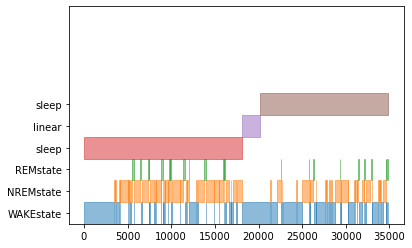

In [77]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

var_keys = ['WAKEstate','NREMstate','REMstate']


y = np.arange(len(var_keys + list(epoch_df.environment))+1)*.1

for i,key in enumerate(var_keys):
    for pair in states_dict[key]:
        plt.axvspan(pair[0], pair[1],y[i],y[i+1], alpha=0.5,color=cmap(i*.1))

for ep in epoch_df.itertuples():
    i+=1
    plt.axvspan(ep.startTime, ep.stopTime,y[i],y[i+1], alpha=0.5,color=cmap(i*.1))

ax = plt.gca()
ax.set_yticks(y[:-1]+.05)
ax.set_yticklabels(var_keys + list(epoch_df.environment))


In [47]:
# plt.figure(figsize=(20,4))
# for pair in states_dict['WAKEstate']:
#     plt.axvspan(pair[0], pair[1],0,.1, alpha=0.5,color='r')
# for pair in states_dict['NREMstate']:
#     plt.axvspan(pair[0], pair[1],.1,.2, alpha=0.5,color='g')
# for pair in states_dict['REMstate']:
#     plt.axvspan(pair[0], pair[1],.2,.3, alpha=0.5,color='b')
# for pair in states_dict['WAKEtheta']:
#     plt.axvspan(pair[0], pair[1],.3,.4, alpha=0.5,color='y')
# for pair in states_dict['WAKEnontheta']:
#     plt.axvspan(pair[0], pair[1],.4,.5, alpha=0.5,color='orange')
# for pair in states_dict['THETA']:
#     plt.axvspan(pair[0], pair[1],.5,.6, alpha=0.5,color='teal')
# for pair in states_dict['nonTHETA']:
#     plt.axvspan(pair[0], pair[1],.6,.7, alpha=0.5,color='magenta')

# for i,ep in enumerate(epoch_df.itertuples()):
#     plt.axvspan(ep.startTime, ep.stopTime,.7+i*.1,.8+i*.1, alpha=0.5)
# plt.xlabel('time (sec)')
# ax = plt.gca()
# ax.set_yticks(np.arange(0,1,.1)+.05)

# ax.set_yticklabels(['WAKEstate','NREMstate','REMstate','WAKEtheta','WAKEnontheta','THETA','nonTHETA','sleep','zigzag','sleep'])

In [48]:
unit_mat = functions.get_participation(st.data,
                                    ripple_epochs.starts,
                                    ripple_epochs.stops)

[Text(0, 0.05, 'WAKEstate'),
 Text(0, 0.15000000000000002, 'NREMstate'),
 Text(0, 0.25, 'REMstate'),
 Text(0, 0.35000000000000003, 'sleep'),
 Text(0, 0.45, 'linear'),
 Text(0, 0.55, 'sleep')]

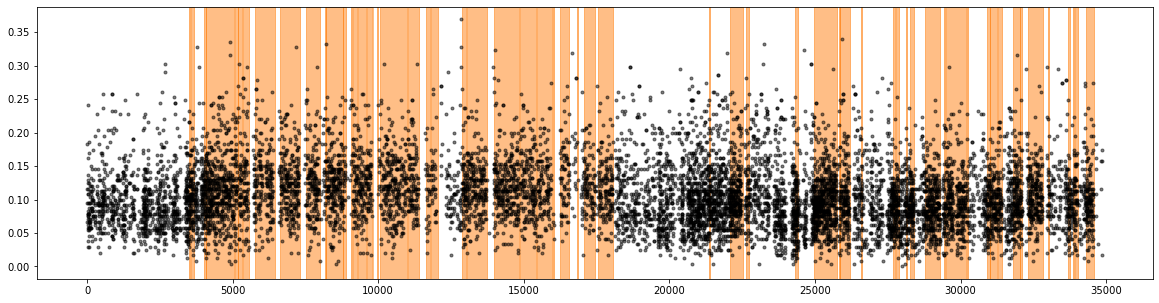

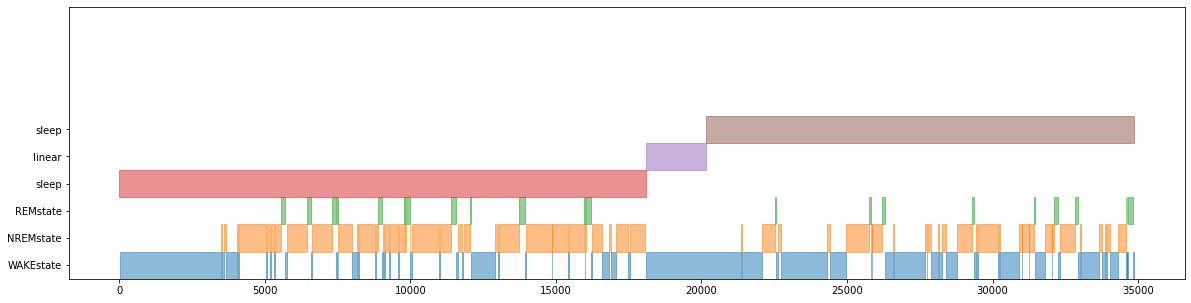

In [83]:
plt.figure(figsize=(20,5))
plt.plot(ripple_epochs.starts, np.mean(unit_mat,axis=0),'.k',alpha=.5)


for pair in states_dict['NREMstate']:
    plt.axvspan(pair[0], pair[1], alpha=0.5,color=cmap(1*.1))

# plt.axvspan(epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[0], facecolor='r', alpha=0.25,zorder=-1000)

plt.figure(figsize=(20,5))

cmap = matplotlib.cm.get_cmap('tab20')

var_keys = ['WAKEstate','NREMstate','REMstate']

y = np.arange(len(var_keys + list(epoch_df.environment))+1)*.1

for i,key in enumerate(var_keys):
    for pair in states_dict[key]:
        plt.axvspan(pair[0], pair[1],y[i],y[i+1], alpha=0.5,color=cmap(i*.1))

for ep in epoch_df.itertuples():
    i+=1
    plt.axvspan(ep.startTime, ep.stopTime,y[i],y[i+1], alpha=0.5,color=cmap(i*.1))
ax = plt.gca()
ax.set_yticks(y[:-1]+.05)
ax.set_yticklabels(var_keys + list(epoch_df.environment))

Text(0.5, 0, 'time (sec)')

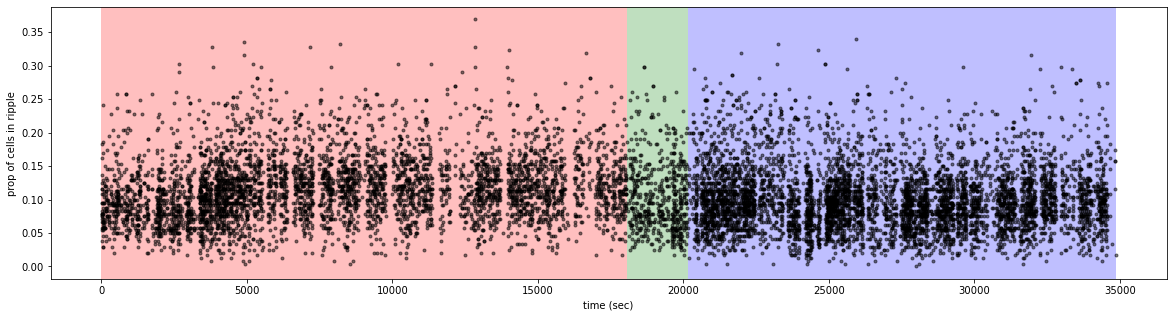

In [5]:
plt.figure(figsize=(20,5))
plt.plot(ripple_epochs.starts, np.mean(unit_mat,axis=0),'.k',alpha=.5)
# plt.axvline(epoch_df.startTime.iloc[0],color='g')
plt.axvspan(epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[0], facecolor='r', alpha=0.25,zorder=-1000)
plt.axvspan(epoch_df.startTime.iloc[1], epoch_df.stopTime.iloc[1], facecolor='g', alpha=0.25,zorder=-1000)
plt.axvspan(epoch_df.startTime.iloc[2], epoch_df.stopTime.iloc[2], facecolor='b', alpha=0.25,zorder=-1000)
plt.ylabel('prop of cells in ripple')
plt.xlabel('time (sec)')

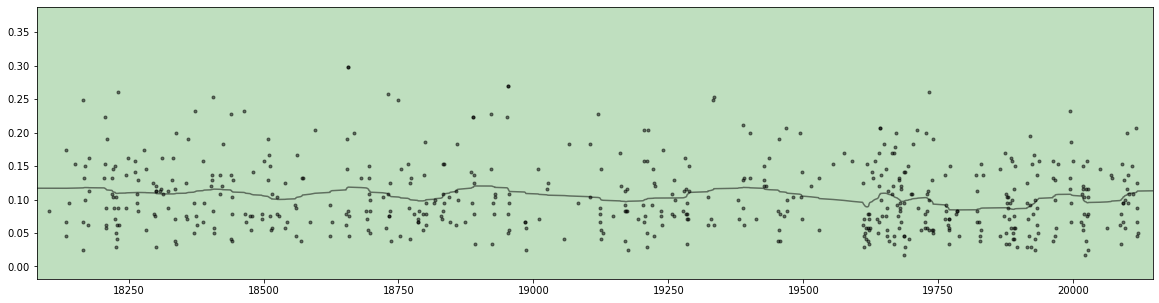

In [6]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(20,5))
plt.plot(ripple_epochs.starts, np.mean(unit_mat,axis=0),'.k',alpha=.5)
plt.plot(ripple_epochs.starts, gaussian_filter1d(np.mean(unit_mat,axis=0),10),'k',alpha=.5)
plt.xlim(epoch_df.startTime.iloc[1], epoch_df.stopTime.iloc[1])
plt.axvspan(epoch_df.startTime.iloc[1], epoch_df.stopTime.iloc[1], facecolor='g', alpha=0.25,zorder=-1000)

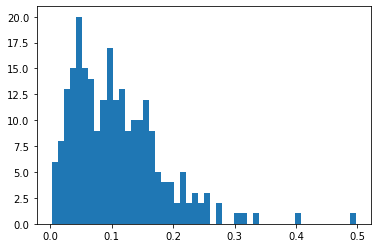

In [84]:
plt.hist(np.mean(unit_mat,axis=1),50)
plt.show()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

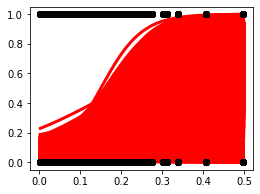

In [140]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit

plt.figure(1, figsize=(4, 3))

for i in range(unit_mat.shape[1]):
    y = unit_mat[:,i]
    X = unit_mat.mean(axis=1)
    X = X[:, np.newaxis]

    clf = LogisticRegression(C=1e5)
    clf.fit(X, y)

    plt.scatter(X.ravel(), y, color="black", zorder=20)
    X_test = np.linspace(X.min(), X.max(), 300)

    loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
    plt.plot(X_test, loss, color="red", linewidth=3)

# plt.plot(unit_mat.mean(axis=1),unit_mat[:,0],'.k',alpha=.2)
# plt.show()

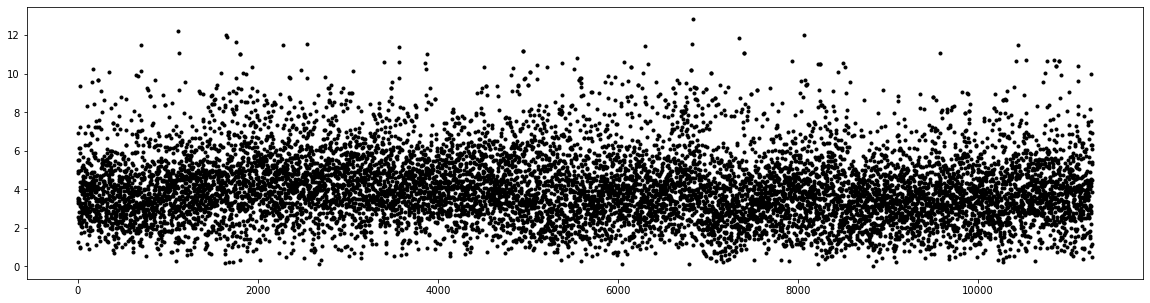

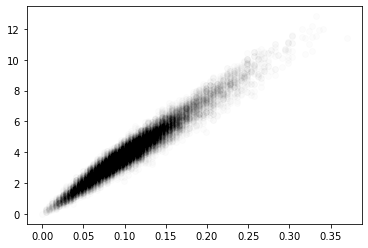

In [120]:
plt.figure(figsize=(20,5))
test = unit_mat.mean(axis=1) @ unit_mat

plt.plot(test,'.k')

plt.figure()
plt.scatter(unit_mat.mean(axis=0),test,color='k',alpha=.01)